<a href="https://colab.research.google.com/github/Pakeith0805/SparkPlus_Assignment/blob/main/Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

SparkPlusの採用課題です。

# 前処理

In [15]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix

In [16]:
# ちゃんとgpuになってるか確認。
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [17]:
# 前処理をまとめる
transform = transforms.Compose([
    transforms.ToTensor(), # 画像をTensorクラスに変えて、チャネルファーストに変えてくれる。
    transforms.Normalize((0.5,), (0.5,)) # 平均、標準偏差を0.5に
])

# 訓練用データセットと検証用データセットを作成
train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
vilidation_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

In [18]:
# データを作る。
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
validation_dataloader = DataLoader(vilidation_dataset, batch_size=32, shuffle=False)

In [19]:
# CNNを実装。
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 32×32の画像が16×16になる。
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 16×16の画像が8×8になる。
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2), # 8×8の画像が4×4になる。
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1), # RGBなのでin_channelsは3、畳み込むたびに2ずつ画像が小さくなるため、2補う。
            nn.ReLU(inplace=True),
        )
        self.classifier = nn.Linear(in_features=4 * 4 * 128, out_features=num_classes) # in_featuresには1次元ベクトルにして渡す。4×4が128個ある。out_featuresは何個に分類するか。
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1) # x.size(0)はバッチ数を表す。(32, 4×4×128)という形になる。
        x = self.classifier(x)
        return x

In [20]:
# modelを作成
model = CNN(10) # 10はクラス数
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
  )
  (classifier): Linear(in_features=2048, out_features=10, bias=True)
)

In [21]:
# 損失関数とoptimizerを設定
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4) # weight_decayで重みづけが大きくなりすぎないようにしている。

In [22]:
# 学習のループ
num_epochs = 15
losses = []
accs = []
val_losses = []
val_accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    y_true = []  # 正解ラベルを保存
    y_pred = []  # 予測ラベルを保存
    for imgs, labels, in train_dataloader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad() # 勾配の初期化
        output = model(imgs)
        loss = criterion(output, labels)
        loss.backward()
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        optimizer.step()
        y_true.extend(labels.cpu().numpy())  # GPU->CPU
        y_pred.extend(pred.cpu().numpy())  # GPU->CPU
    running_loss /= len(train_dataloader)
    running_acc /= len(train_dataloader)
    losses.append(running_loss)
    #accs.append(running_acc)
    accs.append(running_acc.cpu())
#
# validationのループ
#
    val_running_loss = 0.0
    val_running_acc = 0.0
    y_val_true = []  # 正解ラベルを保存
    y_val_pred = []  # 予測ラベルを保存
    for val_imgs, val_labels in validation_dataloader:
        val_imgs = val_imgs.to(device)
        val_labels = val_labels.to(device)
        val_output = model(val_imgs)
        val_loss = criterion(val_output, val_labels)
        val_running_loss += val_loss.item()
        val_pred = torch.argmax(val_output, dim=1)
        val_running_acc += torch.mean(val_pred.eq(val_labels).float())
        # ラベルを保存
        y_val_true.extend(val_labels.cpu().numpy())  # GPU->CPU
        y_val_pred.extend(val_pred.cpu().numpy())  # GPU->CPU

    val_running_loss /= len(validation_dataloader)
    val_running_acc /= len(validation_dataloader)
    val_losses.append(val_running_loss)
    #val_accs.append(val_running_acc)
    val_accs.append(val_running_acc.cpu())
    print("epoch: {}, loss: {}, acc: {}, \
     val loss: {}, val acc: {}".format(epoch, running_loss, running_acc, val_running_loss, val_running_acc))

epoch: 0, loss: 1.4136875696618514, acc: 0.48570457100868225,      val loss: 1.0814277108865804, val acc: 0.6135183572769165
epoch: 1, loss: 0.9531046557678142, acc: 0.6645673513412476,      val loss: 0.901410843617619, val acc: 0.6869009733200073
epoch: 2, loss: 0.761547465947524, acc: 0.732065737247467,      val loss: 0.772724870675669, val acc: 0.7353234887123108
epoch: 3, loss: 0.6517103380277534, acc: 0.7715930938720703,      val loss: 0.720971862443339, val acc: 0.7524960041046143
epoch: 4, loss: 0.5709935539876965, acc: 0.8005038499832153,      val loss: 0.7487021908402062, val acc: 0.7437100410461426
epoch: 5, loss: 0.5073970756848043, acc: 0.8230966329574585,      val loss: 0.7317839042542461, val acc: 0.7559903860092163
epoch: 6, loss: 0.4565170176961219, acc: 0.8395113348960876,      val loss: 0.7760225215468544, val acc: 0.7479033470153809
epoch: 7, loss: 0.41400965174477755, acc: 0.855606198310852,      val loss: 0.7277525845712747, val acc: 0.7687699794769287
epoch: 8, lo

# 評価項目

In [31]:
# 正解率
print(accs[-1].cpu())
print(val_accs[-1].cpu())
# 混同行列
cm=confusion_matrix(y_true, y_pred)
val_cm=confusion_matrix(y_val_true, y_val_pred)
print(cm)
print(val_cm)
# 再現率
recall_per_class = cm.diagonal() / cm.sum(axis=1)
val_recall_per_class = val_cm.diagonal() / val_cm.sum(axis=1)
print(recall_per_class)
print(val_recall_per_class)

tensor(0.9123)
tensor(0.7522)
[[4619   22   94   39   29   10   14   33   91   49]
 [  11 4784   10   16    6    4   17    1   44  107]
 [ 105    5 4378   98  140  100   91   36   31   16]
 [  33   18   96 4197  107  319  120   63   29   18]
 [  39    6  112   93 4501   78   71   85    8    7]
 [  18    8   87  320   89 4330   53   69    8   18]
 [  11   13   97  110   60   47 4631   13    9    9]
 [  22    4   38   73   75   78   10 4678    7   15]
 [  80   29   15   25   11    9   15    6 4774   36]
 [  60  109   15   24    5   11    9   13   31 4723]]
[[834  17  23  18   7   3   4  11  61  22]
 [ 17 890   3   7   0   2   3   2  32  44]
 [ 90  11 663  56  44  52  36  29  15   4]
 [ 46  10  72 616  51 115  28  39  14   9]
 [ 39   4  88  53 664  38  35  66  11   2]
 [ 34  10  63 166  30 626  13  48   5   5]
 [ 13  10  48  92  20  14 781   9  12   1]
 [ 34   5  33  42  40  40   4 794   3   5]
 [ 62  17  10   9   1   2   1   2 887   9]
 [ 43 106   8  19   6   2   4   8  34 770]]
[0.9238 

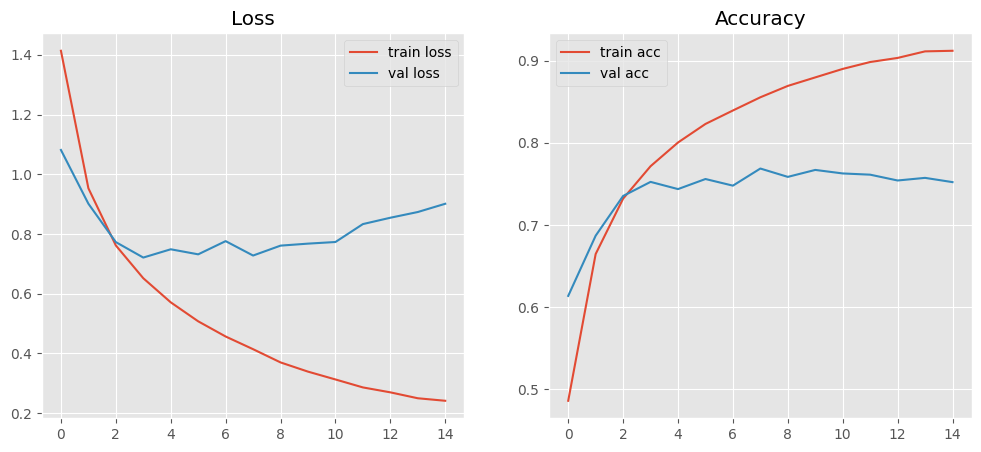

In [24]:
plt.style.use("ggplot")

fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1行2列のサブプロット

# 左のグラフ(損失)
axes[0].plot(losses, label="train loss")
axes[0].plot(val_losses, label="val loss")
axes[0].legend()
axes[0].set_title("Loss")

# 右のグラフ(精度)
axes[1].plot(accs, label="train acc")
axes[1].plot(val_accs, label="val acc")
axes[1].legend()
axes[1].set_title("Accuracy")

plt.show()

In [25]:
print(accs)
print(val_accs)

[tensor(0.4857), tensor(0.6646), tensor(0.7321), tensor(0.7716), tensor(0.8005), tensor(0.8231), tensor(0.8395), tensor(0.8556), tensor(0.8695), tensor(0.8798), tensor(0.8902), tensor(0.8986), tensor(0.9036), tensor(0.9116), tensor(0.9123)]
[tensor(0.6135), tensor(0.6869), tensor(0.7353), tensor(0.7525), tensor(0.7437), tensor(0.7560), tensor(0.7479), tensor(0.7688), tensor(0.7586), tensor(0.7671), tensor(0.7628), tensor(0.7613), tensor(0.7542), tensor(0.7574), tensor(0.7522)]
